# The exponential kernel.

## Functional Methods in Machine Learning 
Final exam

Due date: Monday, 2022/03/07, 13:00


In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from scipy import stats
from sklearn import datasets
import matplotlib.pyplot as plt

import kernel_approximation as ka
import kernel_machine_learning as kml
import stochastic_plots as stoch

# Exponential kernel
from sklearn.metrics.pairwise import laplacian_kernel
from sklearn.metrics.pairwise import rbf_kernel as rbf_sklearn

_ = plt.figure(figsize=(10, 8))

<Figure size 720x576 with 0 Axes>

## Generation of random samples: Inverse transform sampling.

Consider a real-valued random variable whose pdf is $f(x)$. 
The corresponding cdf is
$$
F(x) = \int_{-\infty}^{x} dx' f(x').
$$
This inverse of the cdf ($F^{-1}(p)$) can be used to generate random numbers from this distribution using the following algorithm:

1. Generate a sample from the $U[0,1]$ distribution $\left\{u_m \right\}_{m=1}^M $ with $ u_m \sim U[0,1]$.
2. The sample $\left\{w_m = F^{-1}(u_m) \right\}_{m=1}^M $ is such that $w_m \sim f(w)$. 

For instance, the pdf of an exponential distribution defined on the set of non-negative real numbers is
$$
f(x) = \lambda e^{-\lambda x},   x \ge 0,
$$
with $\lambda > 0$.

The corresponding cdf is
$$
F(x) = \int_{0}^{x} dx \lambda e^{-\lambda x} = 1 - e^{-\lambda x}, \  x \ge 0.
$$
The inverse of the cdf is such that $ F^{-1}(p) = x$.
Since $p = F(x) = 1 -e^{-\lambda x}$, $x = - \log (1-p) / \lambda$. Therefore, 
$$
F^{-1}(p) = -\frac{1}{\lambda} \log (1-p), \ 0 \le p \le 1.
$$
See, for instance, [ https://en.wikipedia.org/wiki/Exponential_distribution ]

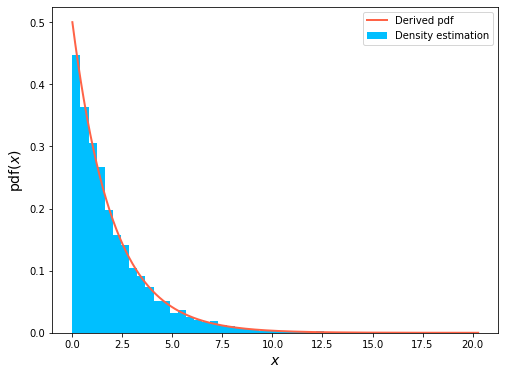

In [2]:
# Generate samples from the exponential distribution.

# Exponential distribution
def exp_pdf(x, gamma):
    return  np.exp(- x / gamma) / gamma

def exp_cdf(x, lambd):
    return 1.0 - np.exp(- x / gamma)

def exp_inverse_cdf(p, gamma):
    return - gamma * np.log(1.0 - p) 

# Inverse transform sampling.

gamma = 2.0

n_samples = 10000
U = np.random.rand(n_samples) # U ~ U[0, 1]
X = exp_inverse_cdf(U, gamma)

# Define a range for the plot. 

X_min, X_max = (np.min(X), np.max(X))

fontsize = 14
stoch.plot_pdf(
    X,
    lambda x: exp_pdf(x, gamma),
    fontsize=fontsize,
)

## Exponential kernel in 1 dimension

The exponential kernel in 1 dimension is
$$
k(x, x') = k(x - x') = \exp\left(- \frac{\left|x - x' \right|}{\gamma} \right).
$$

####  Q1. Express this kernel as the Fourier transform of a density $\hbox{pdf}(x)$.

$$
k(x) = \int_{-\infty}^{\infty} e^{i w x} \text{pdf}(w) \text dw.
$$

The density is proportional to the inverse Fourier transform of $k(x)$:

$$
\hbox{pdf}(w) = \frac{1}{2 \pi} \int_{-\infty}^{\infty} e^{-i x w} k(x) \text dx 
$$

##### Answer

Let us directly compute the wanted *pdf* by replacing the previous expression:

\begin{align*}
    p(w) & \propto \frac{1}{2 \pi} \int_{\mathbb R} e^{-i x w} k(x) \text dx \\
    & = \frac{1}{2 \pi} \int_{\mathbb R} e^{-i x w} e^{- \frac{|x|}{\gamma} } \text dx \\
    & = \frac{1}{2 \pi} \int_{-\infty}^{0} e^{-i x w + \frac{x}{\gamma}} \text dx +
                        \int_{0}^{\infty} e^{-i x w - \frac{x}{\gamma}} \text dx \\
    & = \frac{1}{2 \pi} \left( \frac{e^{-i x w + \frac{x}{\gamma}}}{-iw + \frac{1}{\gamma}} \right]_{-\infty}^{0} +
                        \left( \frac{e^{-i x w - \frac{x}{\gamma}}}{-iw - \frac{1}{\gamma}} \right]_{0}^{\infty} \\
    & = \frac{1}{2 \pi} \left(
                            \frac{1}{-iw + \frac{1}{\gamma}}
                            - \lim_{x \rightarrow -\infty} \frac{e^{-i x w}e^{\frac{x}{\gamma}}}{-iw + \frac{1}{\gamma}}
                            + \lim_{x \rightarrow \infty} \frac{e^{-i x w}e^{-\frac{x}{\gamma}}}{-iw - \frac{1}{\gamma}}
                            - \frac{1}{-iw - \frac{1}{\gamma}}
                         \right) \\
    & \substack{(1) \\ =} \frac{1}{2 \pi} \left( \frac{1}{-iw + \frac{1}{\gamma}} + \frac{1}{iw + \frac{1}{\gamma}} \right) \\
    & = \frac{1}{2 \pi} \frac{-iw + \frac{1}{\gamma} + iw + \frac{1}{\gamma}}{\left(-iw + \frac{1}{\gamma}\right)\left(iw + \frac{1}{\gamma}\right)} \\
    & = \frac{1}{\pi \gamma} \frac{1}{w^2 + \frac{1}{\gamma^2}} \\
    & = \frac{1}{\pi} \frac{\gamma}{1 + \gamma^2w^2} \\
\end{align*}

Where in $(1)$ we used in each limit that $\parallel e^{ix}\parallel = 1$ for any $x \in \mathbb R$, so the complex part of the exponentials is bounded.

At this point we may compare this expression with the Cauchy distribution with parameters $x_0$ and $\xi$:

$$
    f(x; x_0, \xi) = \frac{1}{\pi \xi} \frac{1}{1 + \left(\frac{x - x_0}{\xi}\right)^2}
$$

And we realize that our *pdf* matches to Cauchy's distribution with parameters $x_0=0$ and $\xi=1/\gamma$:

$$
    p(w) = f\left(x; x_0=0, \xi = \frac{1}{\gamma}\right)
$$

In fact, due to this equality we may additionaly assure that $p(w)$ is already normalized.

####  Q2. Derive the cdf and inverse of the cdf for $\hbox{pdf}(w)$. 
The corresponding cumulative distribution function is:

$$
\hbox{cdf}(w) = \int_{-\infty}^w \hbox{pdf}(w') dw'
$$
  
##### Answer

Using the fact that our distribution is a Cauchy, we already know its *cdf* [[1](https://en.wikipedia.org/wiki/Cauchy_distribution)]:

$$
    F(x; x_0, \xi) = \frac{1}{\pi} \arctan\left(\frac{x - x_0}{\xi}\right) + \frac{1}{2} \qquad \forall x \in \mathbb R
$$

In our case:

$$
    F(x) = \frac{1}{\pi} \arctan(\gamma x) + \frac{1}{2} \qquad \forall x \in \mathbb R
$$

Its inverse can be computed directly:

$$
    F^{-1}(q) = \frac{1}{\gamma} \tan\left( \pi \left( q - \frac{1}{2} \right)\right) \qquad \forall q \in (0,1)
$$

#### Q3. Use the method of the inverse to generate random numbers sampled from this $\text{pdf}(w)$.

##### Answer

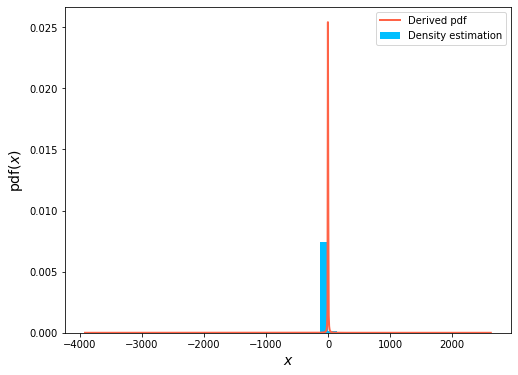

In [3]:
# We call the following functions 'fixed' because they are not
# quite the Cauchy distribution: the gamma parameter is inverted
# and x_0 is fied to 0.

def fixed_cauchy_pdf(x, gamma):
    return 1.0 / np.pi *  gamma / (1.0 + x**2 * gamma**2)

def fixed_cauchy_inverse_cdf(x, gamma):
    return 1.0 / gamma * np.tan( np.pi * (x - 0.5))

# Inverse transform sampling.
gamma = 2.0

n_samples = 10000
U = np.random.rand(n_samples) # U ~ U[0, 1]
X = fixed_cauchy_inverse_cdf(U, gamma)

X_min, X_max = (np.min(X), np.max(X))
stoch.plot_pdf(
    X,
    lambda x: fixed_cauchy_pdf(x, gamma),
    fontsize=14
)

In this last graph the Cauchy distribution cannot be truly appreciated. It is quite probable that in a $10000$ sample we may find rare values that extend the limits of our graph. Let us focus on a fixed interval around $x_0 = 0$, such as $[-5, 5]$, to better see the *pdf*.

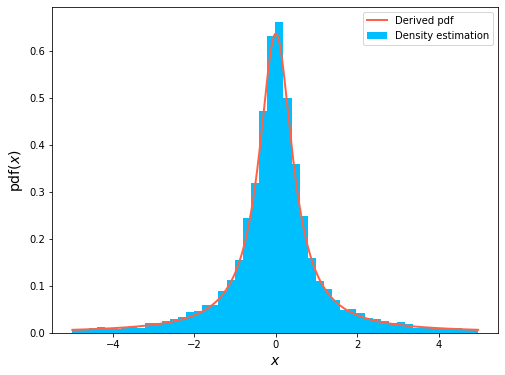

In [4]:
X_reduced = X[np.abs(X) < 5]

stoch.plot_pdf(
    X_reduced,
    lambda x: fixed_cauchy_pdf(x, gamma),
)

As a last sanity check, this graph matches [Wikipedia's](https://en.wikipedia.org/wiki/Cauchy_distribution), where there $\gamma$ is what we called $\xi$. That means we must compare our $\gamma = 2$ graph with their $\gamma = 0.5$ graph, which are reasonably similar.

## Exponential kernel in $D$ dimensions.

Consider the exponential kernel in $D$ dimensions
$$ k(\mathbf{x}, \mathbf{x}') = k(\mathbf{x}- \mathbf{x}') = \exp\left\{- \frac{\lVert \mathbf{x}- \mathbf{x}' \rVert_1}{\gamma} \right\},$$
with the $L_1$ norm
$$ \lVert \mathbf{x}- \mathbf{x}' \rVert_1 = \sum_{d=1}^D \left|x_d \right|.$$

The Fourier transform of the exponential kernel in $D$ dimensions is proportional to a pdf:
$$
\text{pdf}(\mathbf{w}) \propto \int_{\mathbb{R}^D} e^{-i \mathbf{w}^T \mathbf{x}} \exp\left\{- \frac{\lVert \mathbf{x} \rVert_1}{\gamma} \right\} d \mathbf{x}.
$$

#### Q4. Compute the Fourier transform of the exponential kernel in $D$ dimensions.
The Fourier transform of a translationally invariante kernel

$$
k(\mathbf{x}, \mathbf{x}') = k(\mathbf{x} - \mathbf{x}').
$$

is

$$
\text{pdf}(\mathbf{w}) = \frac{1}{\left(2 \pi\right)^D} \int_{\mathbb{R}^D} e^{- i \mathbf{w}^T \mathbf{x}} k(\mathbf{x}) d\mathbf{x}
$$

##### Answer

We follow an analogous procedure to the one in **Q1**:

\begin{align*}
    p(\mathbf w) & \propto \frac{1}{(2 \pi)^D} \int_{\mathbb R^D} e^{-i \mathbf x^T \mathbf w} k(\mathbf x) \text d\mathbf x \\
    & = \frac{1}{(2 \pi)^D} \int_{\mathbb R^D} e^{-i \mathbf x^T \mathbf w} e^{- \frac{\parallel \mathbf x\parallel_1}{\gamma} } \text d\mathbf x \\
    & = \frac{1}{(2 \pi)^D} \int_{\mathbb R^D} \sum_{j=1}^D \text{exp}\left(-i x_j w_j - \frac{|x_j|}{\gamma} \right)  \text d\mathbf x \\
    & = \prod_{j=1}^D \frac{1}{2 \pi} \int_{\mathbb R} \text{exp}\left(-i x_j w_j - \frac{|x_j|}{\gamma}\right) \text dx_j \\
    & = \prod_{j=1}^D p(w_j) \\
\end{align*}

where $p(w_j)$ is the distribution computed in **Q1**: a Cauchy distribution with parameters $x_0=0$ and $\xi = \frac{1}{\xi}$. Since we have been able to express the *pdf* of $\mathbf  w$ as a product of the marginal distributions on its components we know:

1. By definition, the random variables $w_1, \ldots, w_D$ are independent.

2. The *pdf* of $\mathbf w$ is already normalized:
 
$$
    p(\mathbf w) = \prod_{j=1}^D p(w_j)
$$

#### Q5. Use the method of the inverse to generate random numbers sampled from $\text{pdf}(\mathbf{w})$.

##### Answer

We show the behaviour for a 2-dimensional kernel:

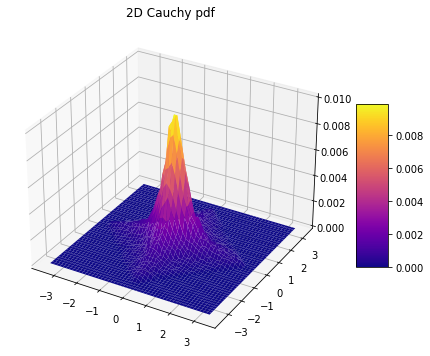

In [5]:
# Inverse transform sampling.
gamma = 2.0

n_samples = 100000

# U ~ U([0, 1]x[0, 1])
U = np.random.rand(n_samples, 2)
X = fixed_cauchy_inverse_cdf(U, gamma)

# Compute the pdf for the clipped points
threshold = 3
X_clipped = X[ np.linalg.norm(X, ord=1, axis=1) < 3 ]

stoch.plot_pdf_3d(X_clipped, n_bins=50, title="2D Cauchy pdf")

Apart from visualizing the *pdf* in 3D we may also graph the *pdf* for each component independently, since they are independent random variables:

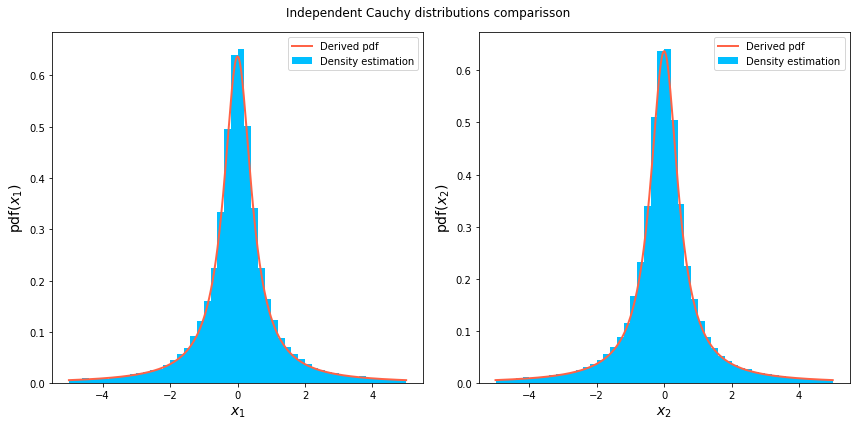

In [6]:
X1, X2 = X[:,0], X[:,1]
X1_clipped, X2_clipped = [ x[np.abs(x) < 5] for x in [X1, X2] ]

_, axis = plt.subplots(1, 2, num=2, figsize=(12, 6))

stoch.plot_pdf(
    X1_clipped,
    lambda x: fixed_cauchy_pdf(x, gamma),
    fontsize=14,
    ax=axis[0]
)
stoch.plot_pdf(
    X2_clipped,
    lambda x: fixed_cauchy_pdf(x, gamma),
    fontsize=14,
    ax=axis[1]
)

plt.suptitle("Independent Cauchy distributions comparisson")
axis[0].set_xlabel("$x_1$", fontsize=fontsize)
axis[0].set_ylabel("pdf($x_1$)", fontsize=fontsize)
axis[1].set_xlabel("$x_2$", fontsize=fontsize)
axis[1].set_ylabel("pdf($x_2$)", fontsize=fontsize)

plt.tight_layout()
plt.show()

#### Q6. Write code to generate random Fourier Features corresponding to the exponential kernel in D dimensions.

Complete the code for the class 

```python
class RandomFeaturesSamplerExp(RandomFeaturesSampler):
```

in the file

``` 
kernel_approximation.py
```

##### Answer



For the rest of the exam we will use a non linear dataset created using the function `create_S_dataset()`. In the following cell we create such dataset and plot it in 3D so we obtain a geometric intuition of our data.

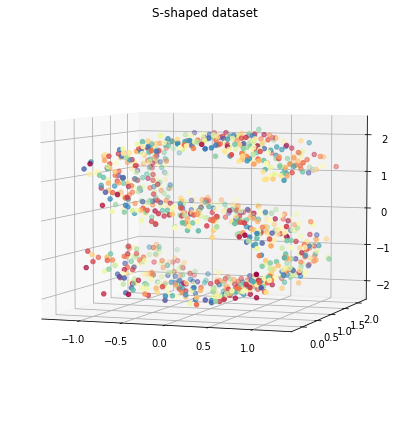

In [7]:
X, color = ka.create_S_dataset(return_color=True)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
my_cmap = plt.cm.Spectral
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=my_cmap)
ax.view_init(5, -70)
plt.title("S-shaped dataset")
plt.tight_layout()
plt.show()

The class `RandomFeaturesSamplerExp` has been implemented in the required file. It only required initializing the $\mathbb w$ weights randomly with the correct Cauchy distribution. 

The next cell shows a series of kernel approximations for different number of random features sampled using the new sampler `RandomFeaturesSamplerExp`.

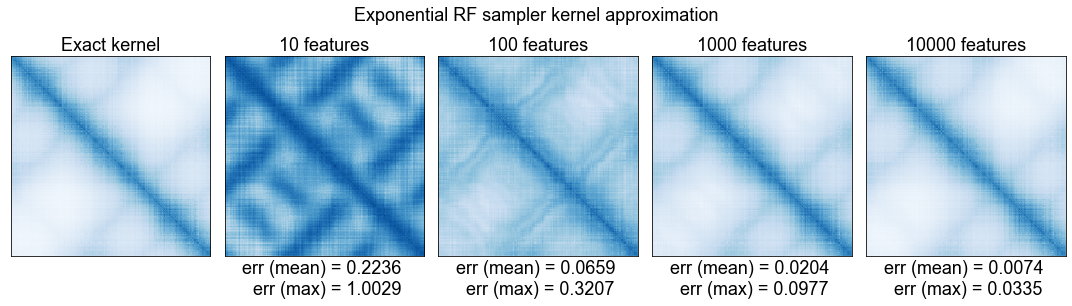

In [8]:
# Prepare class arguments
gamma = 2.0
exp_sampler_kwargs = {'length_scale_kernel': gamma, "sampling_method": "sin+cos"}

def create_exponential_kernel(gamma):
    return lambda X, Y: laplacian_kernel(X, Y, 1.0/gamma)

# Create the kernel
exp_kernel = create_exponential_kernel(gamma)

# Set random features
n_random_features = [10, 100, 1000, 10000]

ka.demo_kernel_approximation_features(
    X,
    exp_kernel,
    ka.RandomFeaturesSamplerExp,
    exp_sampler_kwargs,
    n_random_features,
    sampler_name="Exponential RF sampler"
)

### Generation of Random Fourier Features: Alternative sampling scheme.

Consider the translationally invariant kernel $k\left(\mathbf{x}, \mathbf{x}'\right) = k\left(\mathbf{x} - \mathbf{x}'\right)$, with $\mathbf{x}, \mathbf{x}' \in \mathbb{R}^D$.

Acording to Bochner's theorem, this type of kernel can be expressed as the Fourier transform of a (possibly not normalized) density $p(\mathbf{w})$
$$
k\left(\mathbf{x} - \mathbf{x}'\right) = \int_{-\infty}^{\infty} d\mathbf{w} p\left(\mathbf{w}\right) e^{i \mathbf{w}^T \left(\mathbf{x} - \mathbf{x}'\right)}.
$$
Since the kernel funtion is real and symmetric, this expression can be written as 
$$
k\left(\mathbf{x} - \mathbf{x}'\right) = \int_{-\infty}^{\infty} d\mathbf{w} p\left(\mathbf{w}\right) \cos \left(\mathbf{w}^T \left(\mathbf{x} - \mathbf{x}'\right) \right).
$$

Show that the set of random features
$$
\left\{ \left( \cos \mathbf{w}^T \mathbf{x}, \sin \mathbf{w}^T \mathbf{x} \right); \mathbf{w} \sim p(\mathbf{w})\right\}.
$$
and the set 
$$
\left\{\sqrt{2} \cos \left(\mathbf{w}^T \mathbf{x} + b \right); \ \mathbf{w} \sim p(\mathbf{w}); \ b \sim U[0 , 2 \pi]; \ \mathbf{w} \perp b\right\}
$$
provide the same approximation of the kernel.

#### The kernel approximation using the first type of features is
\begin{align*}
k\left(\mathbf{x}, \mathbf{x}'\right) & = \int_{-\infty}^{\infty} d\mathbf{w} p(\mathbf{w}) \left( \cos \mathbf{w}^T \mathbf{x}, \, \sin \mathbf{w}^T \mathbf{x} \right) \left( \cos \mathbf{w}^T \mathbf{x}', \, \sin \mathbf{w}^T \mathbf{x}' \right)^T \\
& = \int_{-\infty}^{\infty} d\mathbf{w} p(\mathbf{w}) \left( \cos \mathbf{w}^T \mathbf{x}  \, \cos \mathbf{w}^T \mathbf{x}' + \sin \mathbf{w}^T \mathbf{x} \,  \sin \mathbf{w}^T \mathbf{x}' \right) \\
& = \int_{-\infty}^{\infty} d\mathbf{w} p(\mathbf{w}) \cos \left( \mathbf{w}^T \left( \mathbf{x} - \mathbf{x}' \right) \right).
\end{align*}

#### Q7. Derive the kernel approximation using the second type of features.

##### Answer

Let us compute the kernel approximation using the second type of features and obtain the same value as the first time of features. Since we have two random variables ($w \sim p(w)$ and $b \sim U[0, 2\pi]$), we need to take the expectation for both of them:

\begin{align*}
    k(\mathbf x, \mathbf x')
    & = \mathbb E_{b, \mathbf w} \left[\sqrt 2 \cos \left( \mathbf w^T \mathbf x + b \right)
             \cdot \sqrt 2 \cos \left( \mathbf w^T \mathbf x' + b \right) \right] \\
    & = 2 \; \mathbb E_{b, \mathbf w} \left[\cos \left( \mathbf w^T \mathbf x + b \right)
             \cdot \cos \left( \mathbf w^T \mathbf x' + b \right) \right] \\
    & \substack{(1) \\ =} 2 \; \mathbb E_{b, \mathbf w} \left[ \frac{1}{2} \left(\cos \left( \mathbf w^T (\mathbf x - \mathbf x') \right) + \cos \left( \mathbf w^T (\mathbf x + \mathbf x') + 2b \right) \right) \right]\\
    & \substack{(2) \\ =} \mathbb E_{b, \mathbf w} \left[\cos \left( \mathbf w^T (\mathbf x - \mathbf x') \right)\right] \\
    & = \mathbb E_{\mathbf w} \left[\cos \left( \mathbf w^T (\mathbf x - \mathbf x') \right)\right] \\
    & = \int_{\mathbb R} \cos \left( \mathbf w^T (\mathbf x - \mathbf x') \right) \text d \mathbf w p(\mathbf w) \\
\end{align*}

where in $(1)$ we used the product of cosines formula:

$$
    \cos(a) \cdot  \cos(b) = \frac{1}{2} \left( \cos(a+b)  + \cos(a-b) \right)
$$

and in $(2)$ we realized the second term inside the expectation is null:

\begin{align*}
    \mathbb E_{b, \mathbf w} \left[\cos \left( \mathbf w^T (\mathbf x + \mathbf x') + 2b \right) \right]
    = & \; \mathbb E_{\mathbf w} \left[\mathbb E_b \left[ \cos \left( \mathbf w^T (\mathbf x + \mathbf x') + 2b \right) \right] \right] \\
    = & \; \mathbb E_{\mathbf w} \left[ \int_0^{2\pi} p(b) \; \cos \left( \mathbf w^T (\mathbf x + \mathbf x') + 2b \right) \; \text db \right] \\
    = & \; \frac{1}{2\pi} \mathbb E_{\mathbf w} \left[ \int_0^{2\pi} \cos \left( \mathbf w^T (\mathbf x + \mathbf x') + 2b \right) \; \text db \right] \\
    = & \; \frac{1}{4\pi} \mathbb E_{\mathbf w} \left[  \left( \sin \left( \mathbf w^T (\mathbf x + \mathbf x') + 2b \right) \right]_0^{2\pi} \right] \\
    = & \; \frac{1}{4\pi} \mathbb E_{\mathbf w} \left[ 0 \right] \\
    = & \;  0
\end{align*}

#### Q8. Implement the sampling method based on the second type of random features.

Fill in the corresponding code in the file 

``` 
kernel_approximation.py
```

##### Answer

The cosine method has been implemented in the respective file. We may use this new sampling method by setting the parameter `sampling_method` to `cos`.

The following cell shows a series of kernel approximations for different number of random features sampled using the new sampling method with the sampler implemented in **Q6**:

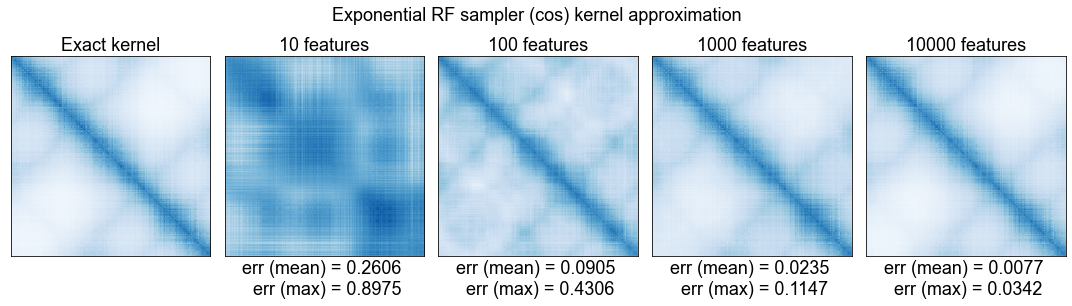

In [9]:
# Prepare class arguments
gamma = 2.0
exp_sampler_kwargs_cos = {'length_scale_kernel': gamma, "sampling_method": "cos"}

# Set random features
n_random_features = [10, 100, 1000, 10000]

ka.demo_kernel_approximation_features(
    X,
    exp_kernel,
    ka.RandomFeaturesSamplerExp,
    exp_sampler_kwargs_cos,
    n_random_features,
    sampler_name="Exponential RF sampler (cos)"
)

The only relevant detail in the implementation was figuring our the `normalization_factor`. Let us look back at the sine and cosine method to understand this value. Using it, we may approximate the kernel with the following development (obtained from the class lectures):

\begin{align*}
    k(\mathbf x, \mathbf x')
    & = \int_{\mathbb R^D} p(\mathbf w) \cos \left( \mathbf w^T (\mathbf x - \mathbf x') \right) \text d \mathbf w  \\
    & = \int_{\mathbb R^D} p(\mathbf w) \left(
        \cos\left(\mathbf w^T \mathbf x \right)
        \cos\left(\mathbf w^T \mathbf x' \right)
        + \sin\left(\mathbf w^T \mathbf x \right)
        \sin\left(\mathbf w^T \mathbf x' \right)
        \right) \text d \mathbf w  \\
    & = \int_{\mathbb R^D} p(\mathbf w)
        \begin{pmatrix} \cos\left(\mathbf w^T \mathbf x \right) & 
                        \sin\left(\mathbf w^T \mathbf x \right) \end{pmatrix}
        \begin{pmatrix} \cos\left(\mathbf w^T \mathbf x' \right) \\
                        \sin\left(\mathbf w^T \mathbf x' \right) \end{pmatrix}
        \text d \mathbf w  \\
    & \approx \frac{1}{J}\sum_{j=1}^J 
        \begin{pmatrix} \cos\left(\mathbf w_j^T \mathbf x \right) & 
                        \sin\left(\mathbf w_j^T \mathbf x \right) \end{pmatrix}
        \begin{pmatrix} \cos\left(\mathbf w_j^T \mathbf x' \right) \\
                        \sin\left(\mathbf w_j^T \mathbf x' \right) \end{pmatrix} \\
    & = \left(\hat \phi_J(x) \right)^T \hat \phi_J(x') \quad \substack{J \rightarrow \infty \\ \longrightarrow} \quad  k(\mathbf x - \mathbf x')
\end{align*}

where

$$ 
\hat \phi_J(x) = \frac{1}{\sqrt J} \;
\begin{pmatrix}
    \cos\left(\mathbf w_1^T \mathbf x \right) \\
    \sin\left(\mathbf w_1^T \mathbf x \right) \\
    \vdots \\
    \cos\left(\mathbf w_J^T \mathbf x \right) \\
    \sin\left(\mathbf w_J^T \mathbf x \right)
\end{pmatrix}.
$$

The so-called *normalization factor* is the inverse of the constant multiplying our feature vector, $\sqrt J$ in this case. Let us derive an analogous development for the cosine method to find its normalization factor:

\begin{align*}
    k(\mathbf x, \mathbf x')
    & = \int_{\mathbb R^D \times [0,2\pi]} p(\mathbf w) \cos \left( \mathbf w^T (\mathbf x - \mathbf x') \right) \text d \mathbf w \\
    & = \int_{\mathbb R^D \times [0,2\pi]} p(\mathbf w) p(b)
        \left( \sqrt 2 \cos \left( \mathbf w^T \mathbf x + b) \right) \right)
        \left( \sqrt 2 \cos \left( \mathbf w^T \mathbf x' + b) \right) \right)
        \text d \mathbf w \text db \\
    & = 2 \; \int_{\mathbb R^D \times [0,2\pi]} p(\mathbf w) p(b)
        \left( \cos \left( \mathbf w^T \mathbf x + b) \right) \right)
        \left( \cos \left( \mathbf w^T \mathbf x' + b) \right) \right)
        \text d \mathbf w \text db \\
    & \approx \frac{2}{J}\sum_{j=1}^J 
        \cos \left( \mathbf w_j^T \mathbf x + b_j \right)
        \cos \left( \mathbf w_j^T \mathbf x' + b_j \right)\\
    & = \left(\hat \phi_J(x) \right)^T \hat \phi_J(x') \quad \substack{J \rightarrow \infty \\ \longrightarrow} \quad  k(\mathbf x - \mathbf x')
\end{align*}

where

$$ 
\hat \phi_J(x) = \sqrt \frac{2}{J} \;
\begin{pmatrix}
    \cos\left(\mathbf w_1^T \mathbf x + b_1\right) \\
    \vdots \\
    \cos\left(\mathbf w_J^T \mathbf x + b_J \right)
\end{pmatrix}.
$$

Therefore, the normalization factor in the cosine method is $\sqrt{J / 2}$.

As a final note, an intuitive approach geometrical of this method is explain in the paper where random Fourier features were originally proposed [[2](https://people.eecs.berkeley.edu/~brecht/papers/07.rah.rec.nips.pdf)], particularly in Figure 1.

#### Q9. Illustrate that both types of feaures approximate the exponential kernel when $p(\mathbf{w})$ is the inverse Fourier transform of the exponential kernel in $D$ dimensions. 



In the previous questions we already computed a series of kernel approximations for different number of features sampled, for both the exponential kernel with the sine and cosine method; and the exponential kernel with the cosine method.

In the following cell we provide the same approximations computed using the RBF kernel with the sine and cosine sampling method for comparisson.

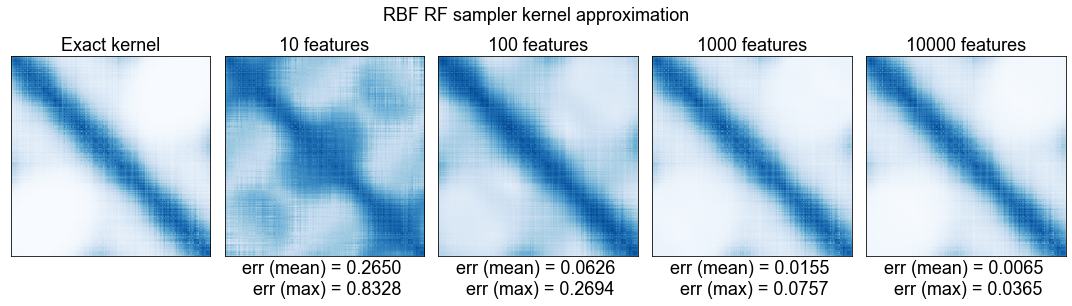

In [10]:
# Prepare class arguments
sigma = 1.0
gamma = 1.0 / (2.0 * sigma**2)
rbf_sampler_kwargs = {'sigma_kernel': sigma, "sampling_method":"sin+cos"}

# RBF kernel function
def create_rbf_kernel(gamma):
    return lambda X, Y: rbf_sklearn(X, Y, gamma=gamma)

# Create the kernel
rbf_kernel = create_rbf_kernel(gamma)

## Plot the approximation to the kernel matrix
n_random_features = [10, 100, 1000, 10000]

ka.demo_kernel_approximation_features(
    X,
    rbf_kernel,
    ka.RandomFeaturesSamplerRBF,
    rbf_sampler_kwargs,
    n_random_features,
    sampler_name="RBF RF sampler"
)

We can see how the convergence of the different methods compared is virtually the same: at each number of features samples the order of both the mean and maximum error are almost equivalent.

In order to further compare the error convergence we can plot the mean error against the number of features samples, as we did for the homework assigment.

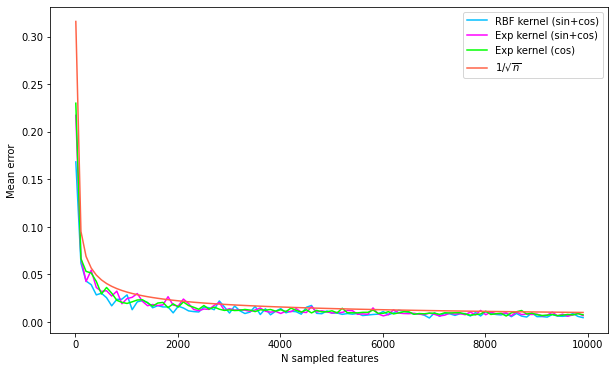

In [18]:
# Create the possible number of features and round them to ints
n_features_range =  np.arange(10, 10**4, 100)

# Create plots
_, ax = plt.subplots(1, 1, figsize=(10, 6))

# Plot RBF error aproximation,
# sin+cos sampling method
stoch.plot_kernel_error(
    X,
    rbf_kernel,
    ka.RandomFeaturesSamplerRBF,
    rbf_sampler_kwargs,
    n_features_range,
    ax=ax,
    label='RBF kernel (sin+cos)'
)

# Plot exp kernel error aproximation,
# sin+cos sampling method
stoch.plot_kernel_error(
    X, 
    exp_kernel, 
    ka.RandomFeaturesSamplerExp,
    exp_sampler_kwargs,
    n_features_range,
    ax=ax,
    label='Exp kernel (sin+cos)',
    color='magenta'
)

# Plot exp kernel error aproximation,
# cos sampling method
stoch.plot_kernel_error(
    X, 
    exp_kernel, 
    ka.RandomFeaturesSamplerExp,
    exp_sampler_kwargs_cos,
    n_features_range,
    ax=ax,
    label='Exp kernel (cos)',
    color='lime'
)

plt.xlabel('N sampled features')
plt.ylabel('Mean error')
plt.plot(n_features_range, 1.0/np.sqrt(n_features_range),
         color='tomato', label=r"$1/\sqrt{n}$")
plt.legend()
plt.show()

First of all, we can again see no real difference between our set of approximations, independently of the kernel approximated and the sampling method used. In order to assure this with greater confidence we would need to repeat the experiment several times and compare both the mean and variance of the errors. A similar analysis will be performed in the next question.

Second of all, just as we did in the homework assigment we can see an empirical convergence of order $O(1/\sqrt n)$. We already theorized in that assigment how this is probably because the MonteCarlo error converges with this rate.

### Q10. Train and evaluate different classifiers.

Solve the classification problem using different kernel methods using the same data in

https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_kernel_approximation.html#sphx-glr-auto-examples-miscellaneous-plot-kernel-approximation-py

**To get more stable results, the process should be repeated for $10$ different random train / test partitions of the data.**

Using 5-fold cross validation on the training data, determine the optimal values of the hyperparameter for the following cases: 
1. Non-linear SVM + RBF kernel [C, gamma]
2. Linear SVM + RBF random features [C, gamma, n_features]
3. Linear SVM + RBF Nyström features [C, gamma, n_features]
4. Non-linear SVM + exponential kernel [C, length_scale] 
5. Linear SVM + exponential random features [C, length_scale, n_features]
6. Linear SVM + exponential Nyström features [C, length_scale, n_features]

##### NOTES
* Determine the hyperparameter grid on which the search is made using references from the literature. Include those references in the Chicago citation format ( https://www.chicagomanualofstyle.org/tools_citationguide/citation-guide-2.html).

* It may be useful to vary one of the hyperparameters while keeping the other fixed (include those plots in your report). For instance, for $n_{features}$. 

##### REPORT:
* Plot the curve that traces the dependence of the CV, training and test error as a function of $n_{features}$ for a fixed value of the other parameters.
* Train final models with the values of the optimal hyperparameters.  
* Provide in a table the mean and the standard deviation of the training error, the cross-validation error and test error for each of the 6 methods considered.
* Provide in a table the mean and the standard deviation of the times for the cross-validation step, for the final training time, and for the prediction time in the test set. To this end, use the Python library $\texttt{timeit}$.

### Sklearn resources.

1. Non-linear SVM for classification: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

2. Linear SVM for classification: https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html

3. Cross-validation: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV

4. Timing and accuracy plots for random Fourier Features and Nyström features: https://scikit-learn.org/stable/modules/generated/sklearn.kernel_approximation.RBFSampler.html